In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

from clean_data import CLEANED_DATA_DIR, RAW_DATA_DIR

PLOT_DIR = "Images"
MODEL_DIR = "Model Output"

In [2]:
cached_cleaned = os.path.join(CLEANED_DATA_DIR, "cleaned_data.csv")
data = pd.read_csv(cached_cleaned,
                   parse_dates=["RECORDED_A"])

C:\Users\Andrew\Anaconda3\envs\uoft2016\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (12,14,44,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


With the loaded data, we make plots to get an idea of the relationship between speed and
other variables in the model; in particular, slope and distance to intersection.

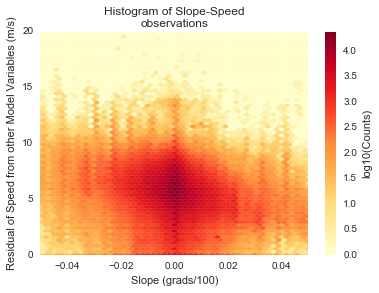

In [7]:
plt.hexbin("SLOPE_TF", "SPEED", data=data, bins="log", cmap=plt.cm.YlOrRd)
plt.xlim(-0.05, 0.05)
plt.ylim(0, 20)
plt.xlabel("Slope (grads/100)")
plt.ylabel("Residual of Speed from other Model Variables (m/s)")
plt.title("Histogram of Slope-Speed\nobservations")
cbar = plt.colorbar()
cbar.set_label("log10(Counts)")

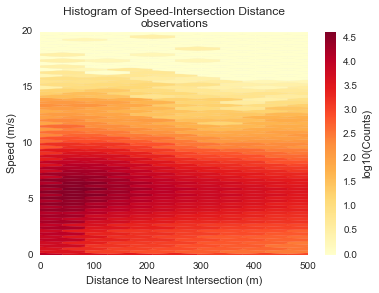

In [8]:
plt.hexbin(data["SIG_DIST"], data["SPEED"], bins="log", cmap=plt.cm.YlOrRd)
plt.xlim(0,500)
plt.ylim(0, 20)
plt.xlabel("Distance to Nearest Intersection (m)")
plt.ylabel("Speed (m/s)")
plt.title("Histogram of Speed-Intersection Distance\nobservations")
cbar = plt.colorbar()
cbar.set_label("log10(Counts)")

Now, we read in the cleaned data, and run a linear model on the speed,
regressed on the explanatory_road variables defined below:

In [9]:
explanatory_road = ("bike_lanes", "sharrows", "bike_path", "SIG_DIST <= 35", "VDF", "volume",
                    "I(volume/(LANES*speed_limit))", "speed_limit", "LANES", "C(RDCLASS)", "SLOPE_TF")

#data = data.sample(frac=0.01)
formula = "SPEED ~ " + " + ".join(explanatory_road)
model = sm.ols(formula=formula, data=data).fit()

data["residual"] = model.resid
data["predicted"] = model.fittedvalues

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SPEED   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 2.326e+04
Date:                Mon, 22 Aug 2016   Prob (F-statistic):               0.00
Time:                        18:41:58   Log-Likelihood:            -3.9550e+06
No. Observations:             1917649   AIC:                         7.910e+06
Df Residuals:                 1917635   BIC:                         7.910e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                             5.5096      0.026    214.661      0.000         5.459     5.560
bike_lanes[T.True]                    0.5177      0.004    129.104      0.000         0.510     0.526
sharrows[T.True]                      0.4317      0.005     83.299      0.000         0.422     0.442
bike_path[T.True]                     1.2244      0.005    236.845      0.000         1.214     1.235
SIG_DIST <= 35[T.True]               -1.2759      0.004   -331.362      0.000        -1.283    -1.268
C(RDCLASS)[T.1]                      -0.2985      0.009    -34.155      0.000        -0.316    -0.281
C(RDCLASS)[T.2]                      -0.1695      0.008    -20.032      0.000        -0.186    -0.153
C(RDCLASS)[T.3]                      -0.5850      0.007    -85.705      0.000        -0.598    -0.572
VDF                                  -0.0109      0.000    -82.393      0.000        -0.011    -0.011
volume                            -9.506e-05    1.3e-05     -7.339      0.000        -0.000 -6.97e-05
I(volume / (LANES * speed_limit))    -0.0186      0.001    -16.081      0.000        -0.021    -0.016
speed_limit                           0.0237      0.000     63.443      0.000         0.023     0.024
LANES                                -0.0334      0.004     -7.613      0.000        -0.042    -0.025
SLOPE_TF                            -25.3317      0.089   -285.519      0.000       -25.506   -25.158
==============================================================================
Omnibus:                    59651.955   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101106.655
Skew:                          -0.278   Prob(JB):                         0.00
Kurtosis:                       3.978   Cond. No.                     2.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Because we aren't making a more complex model of how cyclists behave around intersections, 
we're just assuming that signalized intersections have a constant effect on speed when cyclists 
are within a certain distance of them.
This makes intersections a "black box" in this model.  It would be very interesting to see
an analysis in the future that tries to do a better job of modelling how cyclists' speed
varies around intersections (e.g. taking into account what kind of turn they do, how far away
they are from the intersection on approach/departure from it, what kind of intersection it is,
etc.)

Below, we show how we could select a cutoff for the "black box" intersection
dummy variable.  We simply select a variety of cutoffs to use in the model, 
and choose the one that gives the highest model R-squared.  It can be seen that
the R-squared peaks at a cutoff of 35m on either side of the intersection, so this is
the value that we use in our model.

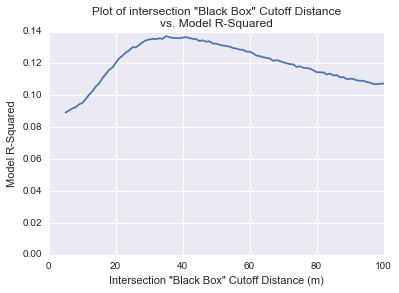

In [25]:
cutoffs = range(5, 101, 1)
r_squareds = []
for cutoff in cutoffs:
    explanatory_road = ("bike_lanes", "sharrows", "bike_path", "SIG_DIST <= %d"%cutoff, "VDF", "volume",
                        "I(volume/(LANES*speed_limit))", "speed_limit", "LANES", "C(RDCLASS)", "SLOPE_TF")
    formula = "SPEED ~ " + " + ".join(explanatory_road)
    test_model = sm.ols(formula=formula, data=data.sample(frac=0.5)).fit()
    
    r_squared = test_model.rsquared
    r_squareds.append(r_squared)
    
plt.plot(cutoffs, r_squareds)
plt.ylim(0,)
plt.title('Plot of intersection "Black Box" Cutoff Distance\nvs. Model R-Squared')
plt.xlabel('Intersection "Black Box" Cutoff Distance (m)')
plt.ylabel('Model R-Squared')

We test for heteroskedasticity in our data using the Breusch-Pagan test using the following code.

Note that while the model i statistically significant, the R-squared of the model is
very small.  We are working with several million data points, so we have enough data for
even a very small effect size to be statistically significant.  However, with such a
small R-squared, we can be pretty confident that heteroskedasticity is not hugely 
affecting our estimates.

In [114]:
hetero_model = sm.ols(formula="I(residual**2) ~ predicted + I(predicted**2)", 
                      data=data).fit()

hetero_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       I(residual ** 2)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2999.
Date:                Sat, 20 Aug 2016   Prob (F-statistic):               0.00
Time:                        01:00:14   Log-Likelihood:            -6.2658e+06
No. Observations:             1917649   AIC:                         1.253e+07
Df Residuals:                 1917646   BIC:                         1.253e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            15.4738      0.155    100.095      0.000        15.171    15.777
predicted            -4.5575      0.059    -77.324      0.000        -4.673    -4.442
I(predicted ** 2)     0.4324      0.006     77.346      0.000         0.421     0.443
==============================================================================
Omnibus:                  2363108.713   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3284325997.244
Skew:                           5.863   Prob(JB):                         0.00
Kurtosis:                     205.403   Cond. No.                     1.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While the above indicates that the data is not particularly heteroskedastic with respect to the
predicted value, we do expect to see heteroskedasticity with respect to one of the predictors:
the intersection black box dummy variable.

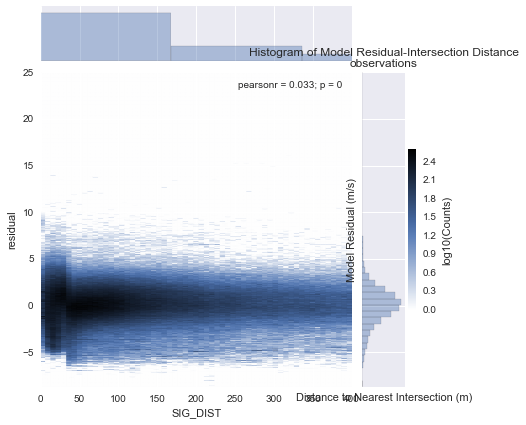

In [16]:
sns.jointplot(x="SIG_DIST", y="residual", data=data, bins="log", kind="hex", xlim=(0,400))
sns.plt.xlabel("Distance to Nearest Intersection (m)")
sns.plt.ylabel("Model Residual (m/s)")
sns.plt.title("Histogram of Model Residual-Intersection Distance\nobservations")
cbar = sns.plt.colorbar()
cbar.set_label("log10(Counts)")

C:\Users\Andrew\Anaconda3\envs\uoft2016\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


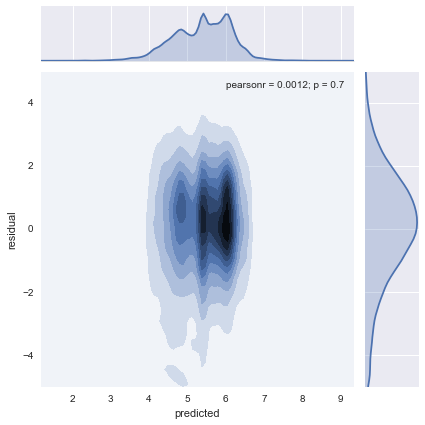

In [17]:
sns.jointplot(x="predicted", y="residual", data=data.sample(frac=0.05), 
              kind="kde", ylim=(-5, 5))

C:\Users\Andrew\Anaconda3\envs\uoft2016\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


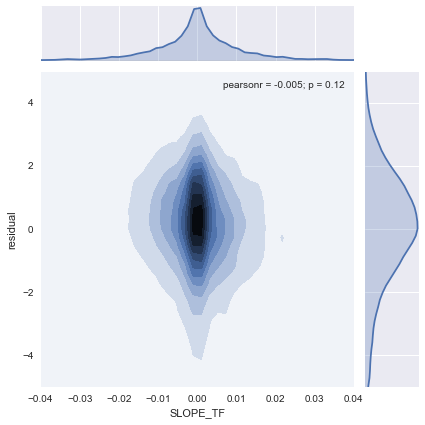

In [18]:
sns.jointplot(x="SLOPE_TF", y="residual", data=data.sample(frac=0.05), 
              kind="kde", xlim=(-0.04, 0.04), ylim=(-5, 5))

C:\Users\Andrew\Anaconda3\envs\uoft2016\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


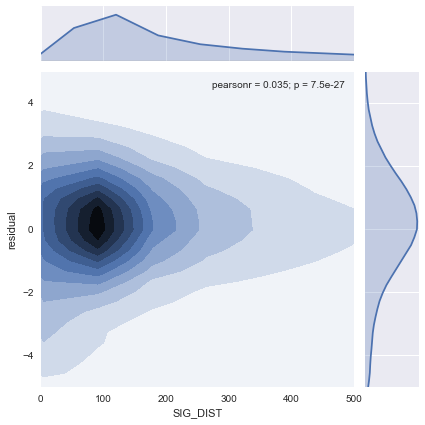

In [19]:
sns.jointplot(x="SIG_DIST", y="residual", data=data.sample(frac=0.05), 
              kind="kde", xlim=(0, 500), ylim=(-5, 5))

In [26]:
grouped = data.groupby("SOURCEOID")
link_aggregated = grouped.aggregate(
    {"residual": {"resid_mean": np.mean,
                  "resid_std": np.std,
                  "rmse": lambda x: np.sqrt(np.mean(x**2))},
     "predicted": {"predicted_mean": np.mean},
     "SPEED": {"speed_mean": np.mean,
               "counts": len,
               "speed_dev_from_network_mean": lambda x: np.mean(x) - data.SPEED.mean()},
     "APP_USER_I": {"unique_users": lambda x: len(np.unique(x))}})

link_aggregated.to_csv(os.path.join(MODEL_DIR, "link_with_model_data.csv"))

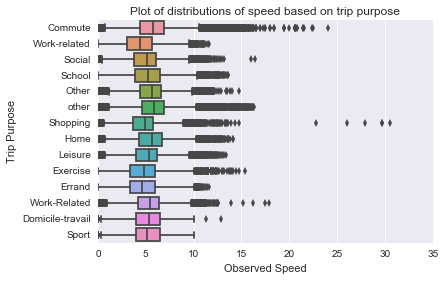

In [21]:
sns.boxplot(x="SPEED", y="PURPOSE", data=data)
sns.plt.ylabel("Trip Purpose")
sns.plt.xlabel("Observed Speed")
sns.plt.title("Plot of distributions of speed based on trip purpose")

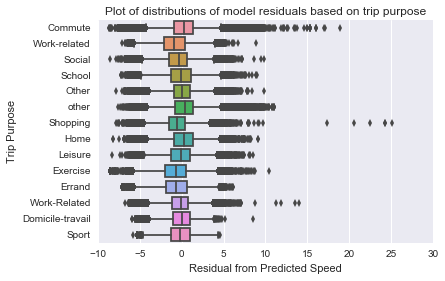

In [22]:
sns.boxplot(x="residual", y="PURPOSE", data=data)
sns.plt.ylabel("Trip Purpose")
sns.plt.xlabel("Residual from Predicted Speed")
sns.plt.title("Plot of distributions of model residuals based on trip purpose")

In [23]:
dates = pd.DatetimeIndex(data.RECORDED_A)
data["time_of_day"] = "Off Peak"
data.loc[(dates.hour >= 8) & (dates.hour < 10), "time_of_day"] = "AM Peak"
data.loc[(dates.hour >= 16) & (dates.hour < 19), "time_of_day"] = "PM Peak"

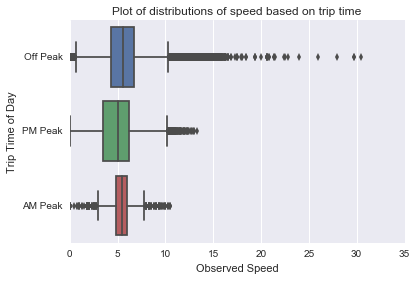

In [24]:
sns.boxplot(x="SPEED", y="time_of_day", data=data)
sns.plt.ylabel("Trip Time of Day")
sns.plt.xlabel("Observed Speed")
sns.plt.title("Plot of distributions of speed based on trip time")

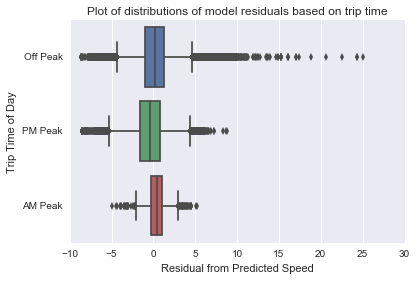

In [25]:
sns.boxplot(x="residual", y="time_of_day", data=data)
sns.plt.ylabel("Trip Time of Day")
sns.plt.xlabel("Residual from Predicted Speed")
sns.plt.title("Plot of distributions of model residuals based on trip time")